# SquiggleFilter Accuracy Analysis

Manage all imports

In [1]:
from sklearn import metrics
from itertools import repeat
from numba import njit
from glob import glob
from scipy import stats
from pyguppy_client_lib.pyclient import PyGuppyClient
from pyguppy_client_lib.helper_functions import package_read, basecall_with_pyguppy

import random, h5py, re, os, mappy

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing as mp
import seaborn as sns

%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

/home/timdunn/SquiggAlign/venv3/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Define globals for selecting input data

In [2]:
data_dir = "../data"
kmer_model_fn, k = f"{data_dir}/dna_kmer_model.txt", 6 # 6-mer model

#virus = "covid"
virus = "lambda"
other = "human"

ref_fn = f"{data_dir}/{virus}/reference.fasta"
virus_fast5_dir = f"{data_dir}/{virus}/fast5"
other_fast5_dir = f"{data_dir}/{other}/fast5"
results_dir = f"./results

virus_max_reads = 1000
other_max_reads = 1000
prefix_lengths = np.array(range(1000,9001,1000))
nprefixes = len(prefix_lengths)

## Generate Expected Viral Reference Signal
Define helper functions

In [56]:
def get_fasta(fasta_fn):
    ''' Get base sequence from FASTA filename. '''
    with open(fasta_fn, 'r') as fasta:
        return ''.join(fasta.read().split('\n')[1:])

def rev_comp(bases):
    ''' Get reverse complement of sequence. '''
    return bases.replace('A','t').replace('T','a')\
        .replace('G','c').replace('C','g').upper()[::-1]

def load_model(kmer_model_fn):
    ''' Load k-mer model file into Python dict. '''
    kmer_model = {}
    with open(kmer_model_fn, 'r') as model_file:
        for line in model_file:
            kmer, current = line.split()
            kmer_model[kmer] = float(current)
    return kmer_model

def discrete_normalize(seq, bits=8, minval=-4, maxval=4):
    ''' Approximate normalization which converts signal to integer of desired precision. '''
    mean = int(np.mean(seq))
    mean_avg_dev = int(np.mean(np.abs(seq - mean)))
    norm_seq = (seq - mean) / mean_avg_dev
    norm_seq[norm_seq < minval] = minval # threshold
    norm_seq[norm_seq > maxval] = maxval 
    norm_seq = ( (norm_seq - minval) * (2**(bits)/(maxval-minval)) ).astype(int)
    return norm_seq

def ref_signal(fasta, kmer_model):
    ''' Convert reference FASTA to expected reference signal (approximate z-scores). '''
    signal = np.zeros(len(fasta))
    for kmer_start in range(len(fasta)-k):
        signal[kmer_start] = kmer_model[fasta[kmer_start:kmer_start+k]]
    return discrete_normalize(signal*100) # increase dist between floats before rounding

Create COVID reference using (z-score normalized) expected k-mer currents for forward/backward reference FASTA

In [57]:
ref_fasta = get_fasta(ref_fn)
kmer_model = load_model(kmer_model_fn)
fwd_ref_sig = ref_signal(ref_fasta, kmer_model)
rev_ref_sig = ref_signal(rev_comp(ref_fasta), kmer_model)
ref = np.concatenate((fwd_ref_sig, rev_ref_sig))

## Read Preparation

Define preprocessing functions for converting raw FAST5 data to normalized alignable signals

In [58]:
def get_stall_end(signal, stall_threshold=3, 
                  stall_events=2, stall_event_len=3):
    ''' Determine the end of the DNA stall region. '''
    
    # take average of a few samples to reduce variation
    events = []
    for event in range(0, len(signal), stall_event_len):
        events.append(np.mean(signal[event:event+stall_event_len]))
    
    # find where we exceed threshold for a few consecutive events
    above_threshold_count = 0
    event_pos = 0
    for event in events:
        event_pos += 1
        if event > stall_threshold:
            above_threshold_count += 1
        else:
            above_threshold_count = 0
        if above_threshold_count == stall_events:
            break
            
    # find where we go back below threshold
    below_threshold_count = 0
    for event in events[event_pos:]:
        event_pos += 1
        if event < stall_threshold:
            below_threshold_count += 1
        else:
            below_threshold_count = 0
        if below_threshold_count == stall_events:
            break
            
    return event_pos * stall_event_len


def trim(signal):
    ''' Trims signal by detecting stall (and eventually adapter). '''
    stall_end = get_stall_end(stats.zscore(signal))
    return signal[stall_end+1000 : stall_end+1000+max(prefix_lengths)], stall_end


def filter_outliers(signal, minval=-4, maxval=4):
    
    # return empty signals as-is
    if not len(signal): return signal
    
    # upper threshold
    for idx, x in enumerate(signal):
        if x > maxval:
            # other values above max -> threshold to max
            if (idx+1 < len(signal) and signal[idx+1] > 3) or \
            (idx > 0 and signal[idx-1] > maxval):
                signal[idx] = maxval
            # otherwise, single outlier -> interpolate
            elif idx == 0:
                signal[idx] = signal[1]
            elif idx+1 == len(signal):
                signal[idx] = signal[idx-1]
            else:
                signal[idx] = (signal[idx-1] + signal[idx+1]) / 2
                
    # lower threshold
    for idx, x in enumerate(signal):
        if x < minval:
            # other values below min -> threshold to min
            if (idx+1 < len(signal) and signal[idx+1] < -3) or \
            (idx > 0 and signal[idx-1] < minval):
                signal[idx] = minval
            # otherwise, single outlier -> interpolate
            elif idx == 0:
                signal[idx] = signal[1]
            elif idx+1 == len(signal):
                signal[idx] = signal[idx-1]
            else:
                signal[idx] = (signal[idx-1] + signal[idx+1]) / 2
                
    return signal

class Read():                                                                                                                                                                                                                                 
    def __init__(self, signal, read_id, offset=0, scaling=1.0):                                                                                                                                                                               
        self.signal = signal                                                                                                                                                                                                                  
        self.read_id = read_id                                                                                                                                                                                                                
        self.total_samples = len(signal)                                                                                                                                                                                                      
        self.daq_offset = offset                                                                                                                                                                                                              
        self.daq_scaling = scaling                                                                                                                                                                                                            
        self.read_tag = random.randint(0, int(2**32 - 1))  

def ba_preprocess_read(uuid, length):
    readname = f"read_{uuid}"
    fast5_file = h5py.File(full_index[uuid], 'r')
    signal = np.array(fast5_file[readname]['Raw']['Signal'][:], dtype=np.int16)
    signal, trimmed = trim(signal)
    if len(signal) < max(prefix_lengths): return None
    signal_dig = fast5_file[readname]['channel_id'].attrs['digitisation']
    signal_offset = fast5_file[readname]['channel_id'].attrs['offset']
    signal_range = fast5_file[readname]['channel_id'].attrs['range']
    signal_scaling = signal_range / signal_dig
    return Read(signal, readname, offset=signal_offset, scaling=signal_scaling)

    
def preprocess_read(uuid):
    ''' Return preprocessed read from specified FAST5 file. '''
    readname = f"read_{uuid}"
    fast5_file = h5py.File(full_index[uuid], 'r')
    signal = np.array(fast5_file[readname]['Raw']['Signal'][:], dtype=np.int16)
    length = signal.shape[0]
    signal, trimmed = trim(signal)
    if len(signal) < max(prefix_lengths): return None
    new_signal = np.array(signal, dtype=float)
    for start in range(0, len(signal), 500):
        new_signal[start:start+500] = \
            discrete_normalize(signal[:start+500])[start:start+500]
    return new_signal, trimmed, length

def get_index(index_filename):
    ''' Read index data structure from file. '''
    index_file = open(index_filename, 'r')
    index = {}
    for line in index_file:
        uuid, fname = re.split(r'\t+', line)
        index[uuid] = fname.rstrip()
    index_file.close()
    return index


def create_index(fast5_dir, force=False):
    '''
    Create file which stores read FAST5 to UUID mappings. 
    '''

    # return existing index if possible
    index_fn = f'{fast5_dir}/index.db'
    if not force and os.path.exists(index_fn):
        return get_index(index_fn)

    # remove existing index
    if os.path.exists(index_fn):
        os.remove(index_fn)

    # create new index    
    index_file = open(index_fn, 'w')

    # iterate through all FAST5 files in directory
    for subdir, dirs, files in os.walk(fast5_dir):
        for filename in files:
            ext = os.path.splitext(filename)[-1].lower()
            if ext == ".fast5":

                # print read uuid and filename to index
                fast5_file = h5py.File(os.path.join(subdir, filename), 'r')
                if 'Raw' in fast5_file: # single-FAST5
                    for readname in fast5_file['Raw']['Reads']:
                        uuid = fast5_file['Raw']['Reads'][readname].attrs['read_id']
                        print('{}\t{}'.format(uuid.decode('utf-8'), \
                                os.path.join(subdir, filename)), file=index_file)
                else: # multi-FAST5
                    for readname in fast5_file:
                        uuid = readname[5:] # remove 'read_' naming prefix
                        print('{}\t{}'.format(uuid, \
                                os.path.join(subdir, filename)), file=index_file)

    # cleanup and return results
    index_file.close()
    return get_index(index_fn)

def segment(signal):
    width = 5
    min_obs = 1
    npts = int((len(signal)*450)/4000)

    # get difference between all neighboring 'width' regions
    cumsum = np.cumsum(np.concatenate([[0.0], signal]))
    cand_poss = np.argsort(np.abs( (2 * cumsum[width:-width]) -
        cumsum[:-2*width] - cumsum[2*width:])).astype(int)[::-1]
    vals = np.abs( (2 * cumsum[width:-width]) - cumsum[:-2*width] - cumsum[2*width:])

    # keep 'npts' best checkpoints
    chkpts = []
    cand_idx = 0
    ct = 0
    blacklist = set()
    while ct < npts:
        edge_pos = cand_poss[cand_idx]
        if edge_pos not in blacklist:
            chkpts.append(edge_pos+width)
            ct += 1

            # blacklist nearby values (only use peaks)
            right = 0
            while edge_pos+right+1 < len(vals) and vals[edge_pos + right] > vals[edge_pos + right+1]:
                right += 1
                blacklist.add(edge_pos+right)
            left = 0
            while edge_pos+left > 0 and vals[edge_pos + left] > vals[edge_pos + left-1]:
                left -= 1
                blacklist.add(edge_pos+left)
        cand_idx += 1

    chkpts = np.sort(chkpts)
    new_signal = [np.mean(signal[0:chkpts[0]])]
    for i in range(len(chkpts)-1):
        new_signal.append(np.mean(signal[chkpts[i]:chkpts[i+1]]))
    return np.array(new_signal)

In [59]:
# create read UUID -> FAST5 filename mapping
virus_index = create_index(virus_fast5_dir)
other_index = create_index(other_fast5_dir)
full_index = {**virus_index, **other_index}

In [60]:
# select random subset of reads
if virus == "covid":
    # COVID reads were reverse-transcribed RNA->DNA, so most are short.
    # To ensure we have 
    virus_readnames = random.choices(list(virus_index.keys()), k=virus_max_reads*1000)
else: 
    virus_readnames = random.choices(list(virus_index.keys()), k=virus_max_reads*2)
other_readnames = random.choices(list(other_index.keys()), k=other_max_reads*2)

## Basecalling and Alignment
Initialize aligner and basecaller for DNA lambda

In [ ]:
aligner = mappy.Aligner(
    fn_idx_in = ref_fn,
    preset = "map-ont",
    best_n = 1,
    k = 15
)

basecaller = PyGuppyClient(
    address = "127.0.0.1:1234", 
    config = "dna_r9.4.1_450bps_fast.cfg",
    server_file_load_timeout=10
)
basecaller.connect()

In [ ]:
def basecall(packets):
    calls = []                                                                                                                                                                                                                            
    sent, rcvd = 0, 0                                                                                                                                                                                                                         
    while sent < len(packets):                                                                                                                                                                                                            
        success = basecaller.pass_read(packets[sent])                                                                                                                                                                                     
        if not success:                                                                                                                                                                                                                       
            print('ERROR: Failed to basecall read.')                                                                                                                                                                                          
            break                                                                                                                                                                                                                             
        else:                                                                                                                                                                                                                                 
            sent += 1                                                                                                                                                                                                                         
    while rcvd < len(packets):                                                                                                                                                                                                            
        result = basecaller.get_completed_reads()                                                                                                                                                                                             
        rcvd += len(result)                                                                                                                                                                                                                   
        calls.extend(result)
    return calls

In [ ]:
ba_virus_scores = np.zeros((nprefixes, virus_max_reads))
ba_other_scores = np.zeros((nprefixes, other_max_reads))
with mp.Pool() as pool:
    for prefix_idx, length in enumerate(prefix_lengths):
        
        # trim reads
        ba_virus_reads = list(filter(None, pool.starmap(
                    ba_preprocess_read, zip(virus_readnames, repeat(length)))))[:virus_max_reads]
        ba_other_reads = list(filter(None, pool.starmap(
                    ba_preprocess_read, zip(other_readnames, repeat(length)))))[:other_max_reads]
                           
        # package read data
        virus_pkts = [package_read(
            read_tag = read.read_tag, 
            read_id = read.read_id, 
            raw_data = read.signal, 
            daq_offset = float(read.daq_offset), 
            daq_scaling = float(read.daq_scaling)
        ) for read in ba_virus_reads]
        other_pkts = [package_read(
            read_tag = read.read_tag, 
            read_id = read.read_id, 
            raw_data = read.signal, 
            daq_offset = float(read.daq_offset), 
            daq_scaling = float(read.daq_scaling)
        ) for read in ba_other_reads]

        # basecall
        virus_calls = basecall(virus_pkts)
        other_calls = basecall(other_pkts)
        
        # align
        for call_idx, call in enumerate(virus_calls):
            try:
                alignment = next(aligner.map(call['datasets']['sequence']))
                ba_virus_scores[prefix_idx, call_idx] = alignment.mapq
            except(StopIteration):
                pass # no alignment
        for call_idx, call in enumerate(other_calls):
            try:
                alignment = next(aligner.map(call['datasets']['sequence']))
                ba_other_scores[prefix_idx, call_idx] = alignment.mapq
            except(StopIteration):
                pass # no alignment

In [ ]:
virus_call_lengths = [len(call['datasets']['sequence']) for call in virus_calls]
other_call_lengths = [len(call['datasets']['sequence']) for call in other_calls]
plt.hist(virus_call_lengths, bins=np.linspace(0, 800, num=100), facecolor='r', alpha=0.5)
plt.hist(other_call_lengths, bins=np.linspace(0, 800, num=100), facecolor='g', alpha=0.5)
plt.legend([virus, other])
plt.xlabel('Call length (4000 samples)')
plt.ylabel('Read Count')
plt.show()

In [ ]:
np.std(virus_call_lengths)

## sDTW Alignment

In [61]:
# trim all reads
with mp.Pool() as pool:
    virus_reads, virus_trims, virus_lengths = \
        list(map(list, zip(*filter(None, pool.map(preprocess_read, virus_readnames)))))
    other_reads, other_trims, other_lengths = \
        list(map(list, zip(*filter(None, pool.map(preprocess_read, other_readnames)))))

In [62]:
if len(virus_reads) < virus_max_reads:
    print(f'ERROR: only {len(virus_reads)} virus reads long enough, requested {virus_max_reads}')
if len(other_reads) < other_max_reads:
    print(f'ERROR: only {len(other_reads)} other reads long enough, requested {other_max_reads}')
virus_reads, virus_trims, virus_lengths = virus_reads[:virus_max_reads], \
    virus_trims[:virus_max_reads], virus_lengths[:virus_max_reads]
other_reads, other_trims, other_lengths = other_reads[:other_max_reads], \
    other_trims[:other_max_reads], other_lengths[:other_max_reads]

In [63]:
@njit()
def sdtw(seq):
    ''' Returns minimum alignment score for subsequence DTW. '''
    
    # initialize cost matrix
    cost_mat = np.zeros((len(seq), len(ref)))
    cost_mat[0, 0] = abs(seq[0]-ref[0])
    for i in range(1, len(seq)):
        cost_mat[i, 0] = cost_mat[i-1, 0] + abs(seq[i]-ref[0])
    
    prev_consec = np.zeros((len(seq)))
    curr_consec = np.zeros((len(seq)))
    
    # compute entire cost matrix
    for j in range(1, len(ref)):
        bonus = 10
        for i in range(1, len(seq)):
            move = cost_mat[i-1, j-1] - prev_consec[i-1]*bonus < cost_mat[i-1, j]
            if move:
                curr_consec[i] = 0
                cost_mat[i, j] = cost_mat[i-1, j-1] - prev_consec[i-1]*bonus + abs(seq[i]-ref[j])
            else:
                curr_consec[i] = min(10, prev_consec[i] + 1)
                cost_mat[i, j] = cost_mat[i-1, j] + abs(seq[i]-ref[j])
        prev_consec = curr_consec[:]
        curr_consec = np.zeros((len(seq)))
    
    # return cost of optimal alignment
    cost_mins = np.zeros((len(prefix_lengths),))
    for i in range(len(prefix_lengths)):
        if prefix_lengths[i] <= len(seq):
            cost_mins[i] = min(cost_mat[prefix_lengths[i]-1,:])
    return cost_mins

In [64]:
# limit cores since each aligner takes ~4GB of RAM to align
with mp.Pool(7) as pool:
    print(f'Aligning {virus} reads...', flush=True)
    virus_scores_list = pool.map(sdtw, virus_reads)
    print(f'Aligning {other} reads...', flush=True)
    other_scores_list = pool.map(sdtw, other_reads)

Aligning lambda reads...
Aligning human reads...


## Analyze Errors
Look at low-scoring human reads and high-scoring lambda reads to determine reason for error

In [ ]:
vscores = np.zeros((nprefixes,len(virus_scores_list)))
for idx, scores in enumerate(virus_scores_list):
    for i in range(nprefixes):
        vscores[i,idx] = scores[i]
oscores = np.zeros((nprefixes,len(other_scores_list)))
for idx, scores in enumerate(other_scores_list):
    for i in range(nprefixes):
        oscores[i,idx] = scores[i]
high_virus = np.argsort(vscores[-1])[::-1]
low_other = np.argsort(oscores[-1])

In [ ]:
# for idx in high_virus[:20]:
#     plt.figure(figsize=(25,5))
#     plt.plot(virus_reads[idx])
#     plt.title(idx)
# plt.show()

for idx in low_other[:20]:
    plt.figure(figsize=(25,5))
    plt.plot(other_reads[idx])
    plt.title(idx)
plt.show()

## Data Analysis

#### Save Results

In [65]:
# move data to numpy array for easy sorting/calculations
virus_scores = np.zeros((nprefixes, len(virus_scores_list)))
for idx, scores in enumerate(virus_scores_list):
    for i in range(nprefixes):
        virus_scores[i,idx] = scores[i]
other_scores = np.zeros((nprefixes, len(other_scores_list)))
for idx, scores in enumerate(other_scores_list):
    for i in range(nprefixes):
        other_scores[i,idx] = scores[i]
        
# save results
os.makedirs(results_dir, exist_ok=True)
np.save(f"{results_dir}/prefix_lengths", prefix_lengths)
np.save(f"{results_dir}/virus_trims", virus_trims)
np.save(f"{results_dir}/virus_lengths", virus_lengths)
np.save(f"{results_dir}/virus_scores", virus_scores)
np.save(f"{results_dir}/other_trims", other_trims)
np.save(f"{results_dir}/other_lengths", other_lengths)
np.save(f"{results_dir}/other_scores", other_scores)

In [ ]:
np.save(f"{results_dir}/ba_virus_scores", ba_virus_scores)
np.save(f"{results_dir}/ba_other_scores", ba_other_scores)

#### Load Results

In [84]:
prefix_lengths = np.load(f"{results_dir}/prefix_lengths.npy")
virus_trims = np.load(f"{results_dir}/virus_trims.npy")
virus_lengths = np.load(f"{results_dir}/virus_lengths.npy")
virus_scores = np.load(f"{results_dir}/virus_scores.npy")
other_trims = np.load(f"{results_dir}/other_trims.npy")
other_lengths = np.load(f"{results_dir}/other_lengths.npy")
other_scores = np.load(f"{results_dir}/other_scores.npy")

In [85]:
ba_virus_scores = np.load(f"{results_dir}/ba_virus_scores.npy")
ba_other_scores = np.load(f"{results_dir}/ba_other_scores.npy")

In [17]:
def get_stats(virus_scores, other_scores, thresh):
    ''' Return F-scores (assumes sorted input). '''
    fscores = np.zeros(nprefixes)
    precs = np.zeros(nprefixes)
    recalls = np.zeros(nprefixes)
    for i in range(nprefixes):
        # short reads don't receive a score, so ignore in accuracy metrics
        long_virus = np.count_nonzero(virus_scores[i])
        short_virus = virus_scores.shape[1]-long_virus
        tp = np.searchsorted(virus_scores[i], thresh) - short_virus
        fn = long_virus - tp
        long_other = np.count_nonzero(other_scores[i])
        short_other = other_scores.shape[1]-long_other
        fp = np.searchsorted(other_scores[i], thresh) - short_other
        precs[i] = 0 if not tp+fp else tp / (tp+fp)
        recalls[i] = 0 if not tp+fn else tp / (tp+fn)  
        fscores[i] = 0 if not tp+fp+fn else tp / (tp + 0.5*(fp + fn))
    return fscores, precs, recalls

In [68]:
# sort arrays (for fast f-score calculation)
virus_scores = np.sort(virus_scores)
other_scores = np.sort(other_scores)
min_score = min(np.min(virus_scores), np.min(other_scores))
max_score = max(np.max(virus_scores), np.max(other_scores))

# calculate all f-scores, and save the best thresholds
best_threshs = np.zeros(nprefixes)
best_fscores = np.zeros(nprefixes)
best_precs = np.zeros(nprefixes)
best_recalls = np.zeros(nprefixes)
for thresh in np.linspace(min_score, max_score, num=100):
    fscores, precs, recalls = get_stats(virus_scores, other_scores, thresh)
    for i in range(nprefixes):
        if fscores[i] > best_fscores[i]:
            best_fscores[i] = fscores[i]
            best_precs[i] = precs[i]
            best_recalls[i] = recalls[i]
            best_threshs[i] = thresh + 0.01
            
np.save(f"{results_dir}/fscores", best_fscores)
np.save(f"{results_dir}/precisions", best_precs)
np.save(f"{results_dir}/recalls", best_recalls)

Plot score distribution for each signal prefix length

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


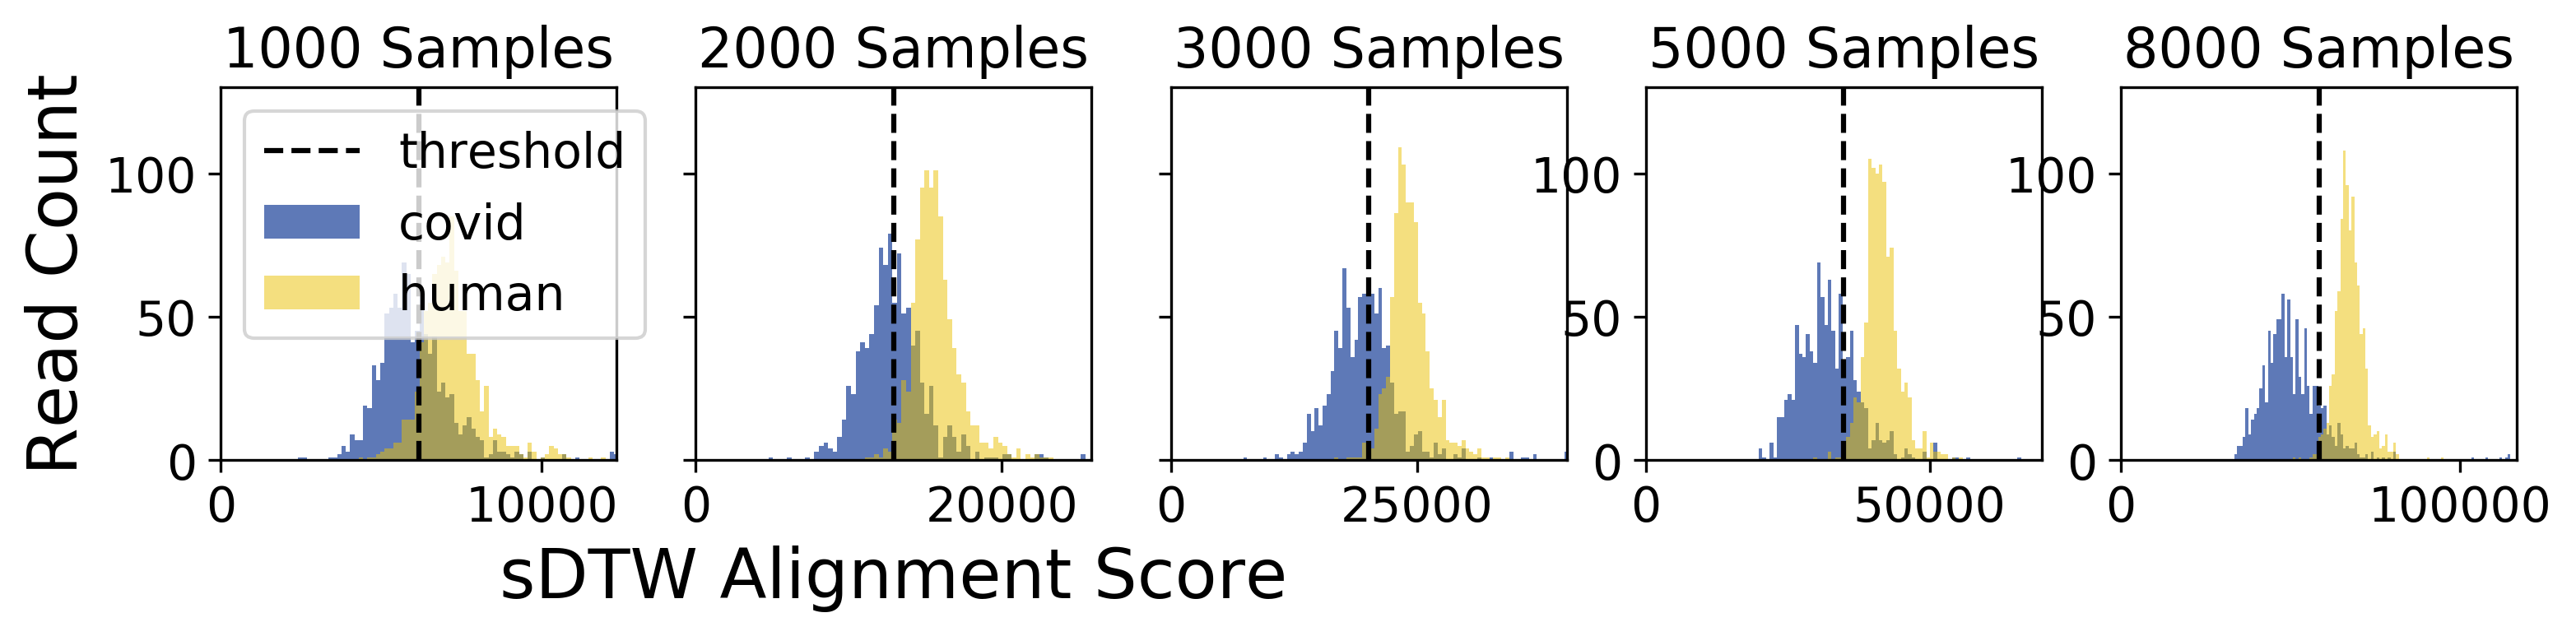

In [31]:
plot_prefixes = [1000, 2000, 3000, 5000, 8000]
best_threshs = [6170, 12935, 20093, 0, 34879, 0, 0, 58345]
fig, ax = plt.subplots(1,len(plot_prefixes), figsize=(12,2))
j = 0
for i, l in enumerate(prefix_lengths):
    if l in plot_prefixes:
        ax[j].set_xlim(0, best_threshs[i]*2)
        minval = min(np.min(virus_scores[i]), np.min(other_scores[i]))
        maxval = max(np.max(virus_scores[i]), np.max(other_scores[i]))
        ax[j].hist(virus_scores[i], bins=np.linspace(minval, maxval, num=100), facecolor='#1a4099', alpha=0.7)
        ax[j].hist(other_scores[i], bins=np.linspace(minval, maxval, num=100), facecolor='#ebc100', alpha=0.5)
        ax[j].axvline(best_threshs[i], color='k', linestyle='--')
        ax[j].set_title('{} Samples'.format(l), fontsize=16)
        ax[j].set_ylim((0,130))
        ax[j].legend().remove()
        j += 1

    ax[0].legend(['threshold', virus, other], loc='upper left')
    ax[1].set_xlabel('sDTW Alignment Score', fontsize=20)
    ax[1].set_yticklabels([])
    ax[2].set_yticklabels([])
    ax[0].set_ylabel('Read Count', fontsize=20)

#plt.tight_layout()
plt.show()

#### Basecall Alignment Score Distribution

In [ ]:
for i, l in enumerate([1000]):
    fig, ax = plt.subplots()
    minval = min(np.min(ba_virus_scores[i]), np.min(ba_other_scores[i]))
    maxval = max(np.max(ba_virus_scores[i]), np.max(ba_other_scores[i]))
    ax.hist(ba_virus_scores[i], bins=np.linspace(minval, maxval, num=100), facecolor='r', alpha=0.5)
    ax.hist(ba_other_scores[i], bins=np.linspace(minval, maxval, num=100), facecolor='g', alpha=0.5)
    ax.legend([virus, other])
    ax.set_xlabel('Alignment Score')
    ax.set_ylabel('Read Count')
    ax.set_title('{} Samples'.format(l))
    plt.show()

Generate accuracy plots for alignment method evaluation

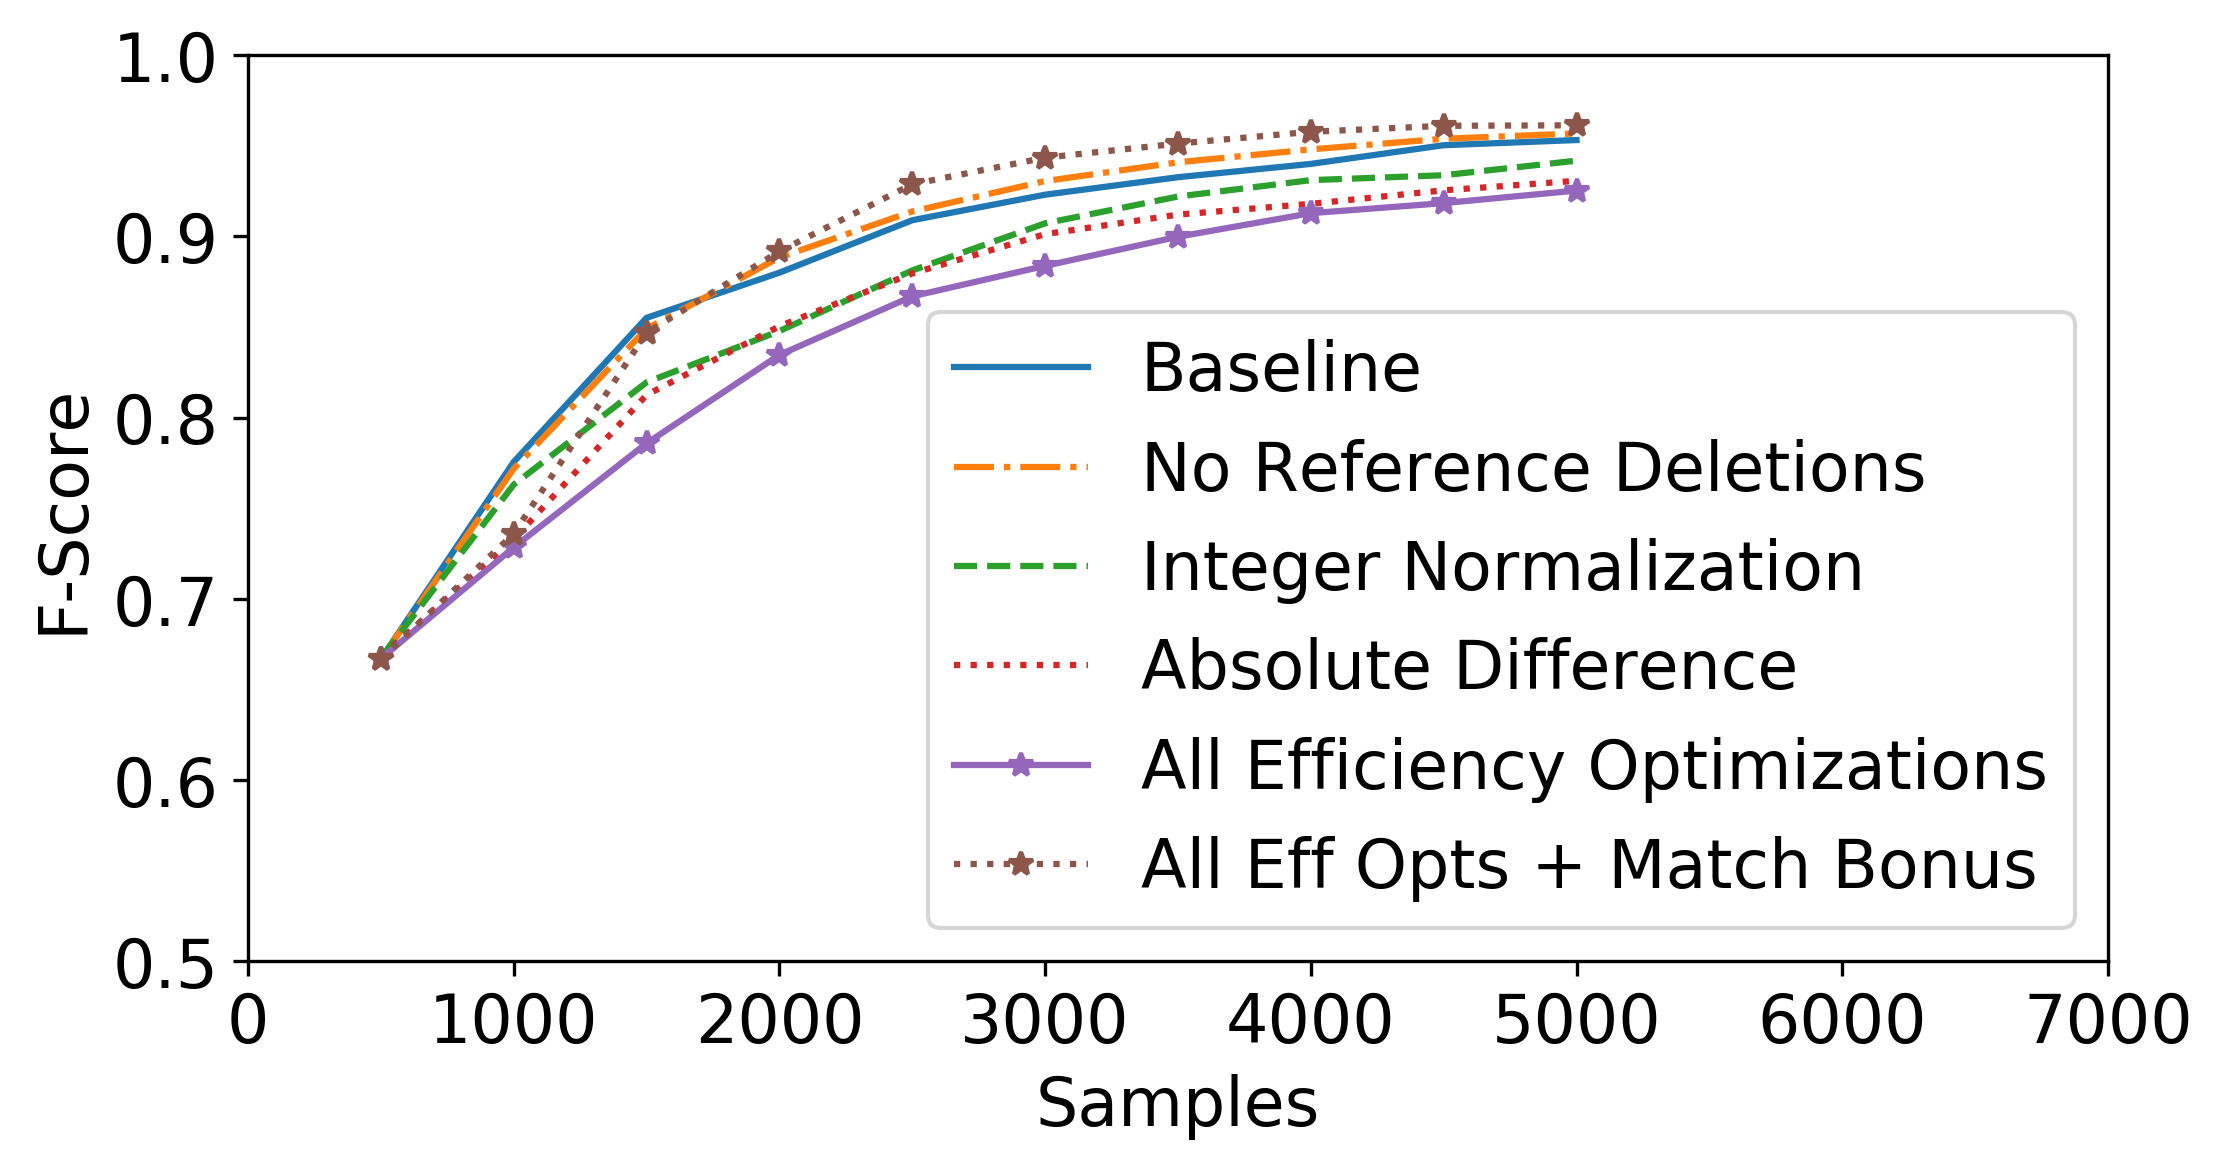

In [80]:
results_dirs = ["final_baseline", "final_no_ref_skip", "final_discrete_norm", "final_abs_value", "final_all", "final_all_bonus_plot"]
linestyles=['-', '-.', '--', ':', '-', ':']
markers=['','','','','*','*']
mpl.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(1,1, figsize=(8,4))
for i, d in enumerate(results_dirs):
    fscores = np.load(f"results/{d}/fscores.npy")
    axs.plot(np.arange(500,5001,500), fscores, marker=markers[i], linestyle=linestyles[i])
axs.set_ylim(0.5,1)
axs.set_xlim(0,7000)
axs.set_xlabel('Samples')
axs.set_ylabel('F-Score')
axs.legend(["Baseline", "No Reference Deletions", "Integer Normalization", "Absolute Difference", "All Efficiency Optimizations", "All Eff Opts + Match Bonus"],)
plt.show()

In [20]:
prefix_lengths

array([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])

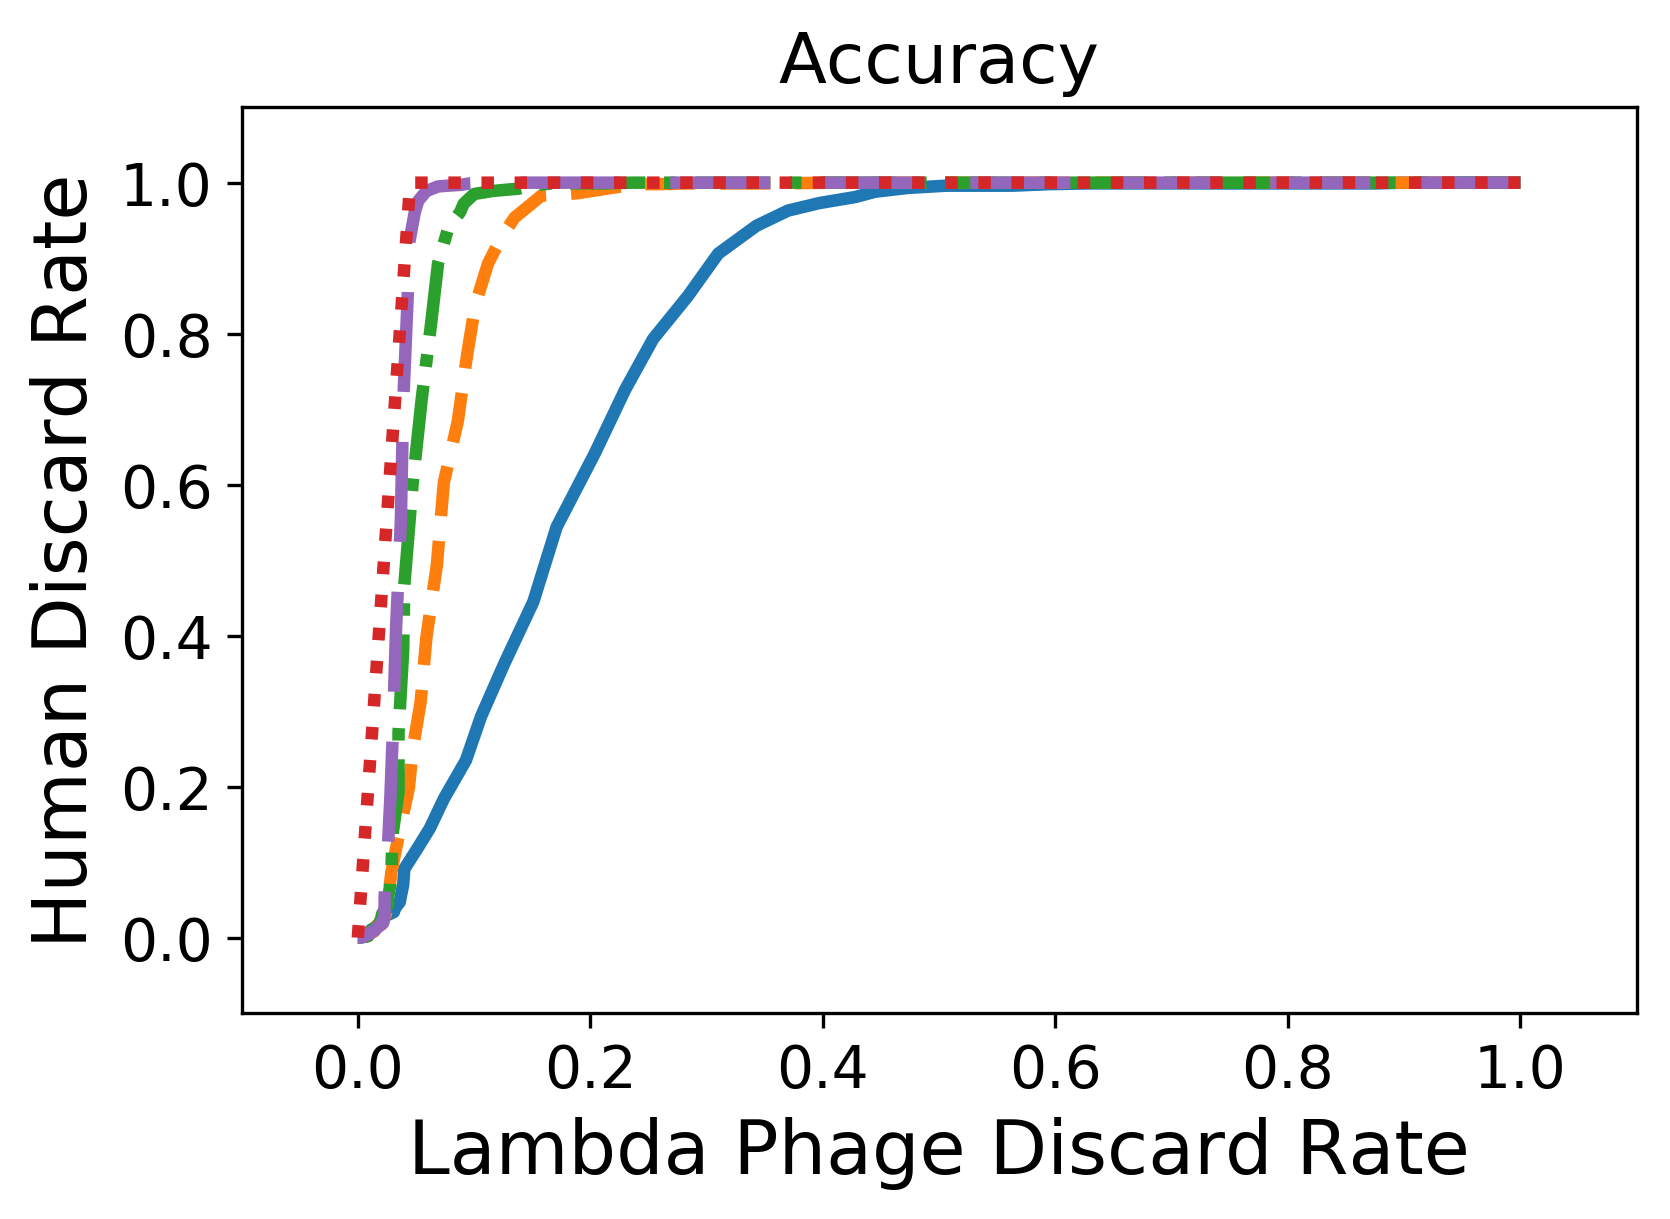

In [11]:
dtw_lengths = [1000, 2000, 3000, 5000]
ba_lengths = [1000]

# initialize plots
mpl.rcParams.update({'font.size': 14})
dtw_indices = [np.where(prefix_lengths == t)[0] for t in dtw_lengths]
ba_indices = [np.where(prefix_lengths == t)[0] for t in ba_lengths]
fig, ax = plt.subplots()
#ax.plot(0, 1, color='k', marker='*', markersize=15, linestyle='None')                                                                                                                                                                        
#ax.plot(np.linspace(0,1,num=20), np.linspace(0,1,num=20), color='k', marker='.', markersize=6, linestyle='')

# all DTW plots
linestyles=['-', '--', '-.', ':', '-']
dashes = [[10,0], [4,2], [6,1.5,1,1.5], [8,4], [8,2,2,2,2,2]]
colors = ['C0', 'C1', 'C2', 'C4', 'C5']
j = 0
for i, l in zip(dtw_indices, dtw_lengths):
    i = int(i)
    minval = min(np.min(virus_scores[i]), np.min(other_scores[i]))-1
    maxval = max(np.max(virus_scores[i]), np.max(other_scores[i]))+1
    thresholds = np.linspace(minval, maxval, num=100)

    other_discard_rate, virus_discard_rate = [], []
    for t in thresholds:
        virus_discard_rate.append(np.sum(virus_scores[i] > t) / len(virus_scores[i]))
        other_discard_rate.append(np.sum(other_scores[i] > t) / len(other_scores[i]))
    ax.plot(virus_discard_rate, other_discard_rate, linestyle=linestyles[j], linewidth=3, dashes=dashes[j], color=colors[j])
    j+=1
    
# all Guppy + Minimap2 plots
for i, l in zip(ba_indices, ba_lengths):
    i = int(i)
    minval = min(np.min(ba_virus_scores[i]), np.min(ba_other_scores[i]))-1
    maxval = max(np.max(ba_virus_scores[i]), np.max(ba_other_scores[i]))+1
    thresholds = np.linspace(minval, maxval, num=100)

    other_discard_rate, virus_discard_rate = [], []
    for t in thresholds:
        virus_discard_rate.append(sum(ba_virus_scores[i] < t) / len(ba_virus_scores[i]))
        other_discard_rate.append(sum(ba_other_scores[i] < t) / len(ba_other_scores[i]))
    ax.plot(virus_discard_rate, other_discard_rate, linestyle=':', linewidth=3, color='C3')
    
ax.set_xlabel('Lambda Phage Discard Rate', fontsize=18)
ax.set_ylabel('Human Discard Rate', fontsize=18)
#ax.set_title('Guppy-lite ')
#ax.legend(#["ideal", "random"] + \
#        [f"SquiggleFilter {x} samples" for x in dtw_lengths] + \
#        [f"Guppy-lite {x} samples" for x in ba_lengths], labelspacing=0, loc="lower right")      
ax.set_xlim((-0.1, 1.1))
ax.set_ylim((-0.1, 1.1))
ax.set_title('Accuracy')
plt.show()

## Read Until Runtime
Analyze runtime as a function of accuracy and multi-stage thresholding

In [37]:
class Reads():
    
    def __init__(self, results_dir):
        self.prop_virus = 0.01        # proportion virus
        self.prop_other = 1 - self.prop_virus
        self.prefix_lengths = np.load(f'{results_dir}/prefix_lengths.npy')

        self.ba_virus_scores = np.load(f'{results_dir}/ba_virus_scores.npy')
        self.virus_scores = np.load(f'{results_dir}/virus_scores.npy')
        self.virus_lengths = np.load(f'{results_dir}/virus_lengths.npy')
        self.avg_virus_length = np.mean(self.virus_lengths)
        #self.avg_virus_length = 11814
        self.virus_trims = np.load(f'{results_dir}/virus_trims.npy')
        self.avg_virus_trim = np.mean(self.virus_trims)

        self.ba_other_scores = np.load(f'{results_dir}/ba_other_scores.npy')
        self.other_scores = np.load(f"{results_dir}/other_scores.npy")
        self.other_lengths = np.load(f"{results_dir}/other_lengths.npy")
        self.avg_other_length = np.mean(self.other_lengths)
        #self.avg_other_length = 12551 # expected human rtDNA length
        self.other_trims = np.load(f"{results_dir}/other_trims.npy")
        self.avg_other_trim = np.mean(self.other_trims)
    
    
class Flowcell():
    
    def __init__(self, channels = 512):
        self.chemistry = 'r9.4.1'
        self.sampling_rate = 4000     # samples/sec
        self.minknow_latency = 0.070 # sec
        self.channels = channels
        
        
class Classifier():
    
    def __init__(self, method='sf', watts=1):
        self.method = method
        if method == 'sf': # SquiggleFilter
            self.throughput = 23_364 * 2000 * watts
            self.latency = 0.0000408
        elif method == 'ba': # BasecallAlign
            self.throughput = 550 * 2000
            self.latency = 0.149
        else:
            raise Exception("Unknown Read Until classifier type.")
    

class Run():
    
    def __init__(self, reads, clf='sf', flowcell=Flowcell(), watts=1):
        self.flowcell = flowcell
        self.clf = Classifier(clf, watts)
        self.reads = reads
        
        self.target_coverage = 30.0
        #self.target_genome_size = 30_000.0 # bases
        self.target_genome_size = 100_000.0 # bases
        self.coverage_bias = 10.0
        self.fwd_tr = 400.0           # bases / sec
        self.rev_tr = 100_000.0       # bases / sec
        self.capture_time = 1.0       # sec

        self.sr = self.flowcell.sampling_rate
    
    def get_simple_runtime(self):
        max_throughput = self.flowcell.channels * self.sr
        virus_time = self.reads.prop_virus * \
            (self.capture_time + self.reads.avg_virus_length/self.sr)
        other_time = self.reads.prop_other * \
            (self.capture_time + self.reads.avg_other_length/self.sr)
        useful_time = self.reads.prop_virus * \
            (self.reads.avg_virus_length-self.reads.avg_virus_trim) / self.sr
        useful_throughput = max_throughput * useful_time / (virus_time + other_time)
        duration = self.target_genome_size * (self.sr/self.fwd_tr) * \
            self.target_coverage * self.coverage_bias / useful_throughput
        return duration
    
    
    def get_read_until_runtime(self, prefix_indices, thresholds):
        
        # get runtime without read until
        max_throughput = self.flowcell.channels * self.sr
        simple_virus_time = self.reads.prop_virus * \
            (self.capture_time + self.reads.avg_virus_length/self.sr)
        simple_other_time = self.reads.prop_other * \
            (self.capture_time + self.reads.avg_other_length/self.sr)
        simple_useful_time = self.reads.prop_virus * \
            (self.reads.avg_virus_length-self.reads.avg_virus_trim) / self.sr
        simple_prop_useful_time = simple_useful_time / \
            (simple_virus_time + simple_other_time)
        
        # What percentage of pores can perform Read Until?
        # - estimate required basecall throughput from simple sequencing
        bc_time = self.reads.prop_virus * self.reads.avg_virus_length/self.sr + \
            self.reads.prop_other * self.reads.avg_other_length/self.sr
        bc_throughput = max_throughput * (bc_time/ (simple_virus_time + simple_other_time))
        prop_ru = min(1.0, self.clf.throughput/bc_throughput)
        prop_simple = 1 - prop_ru
        
        # calculate sequencing runtime for multiple thresholds
        if self.clf.method == 'sf':
            rem_virus_scores = self.reads.virus_scores.copy()
            rem_other_scores = self.reads.other_scores.copy()
        else:
            rem_virus_scores = -self.reads.ba_virus_scores.copy()
            rem_other_scores = -self.reads.ba_other_scores.copy()   
            
        eject_virus_time, eject_other_time = 0, 0
        for i, thresh in zip(prefix_indices, thresholds):
            
            # device continues sequencing as we make a read-until decision
            length = self.reads.prefix_lengths[i]
            samples = length + self.sr * \
                (self.clf.latency + self.flowcell.minknow_latency)
            reversal_latency = samples / (self.rev_tr * (self.sr/self.fwd_tr))
            latency = self.clf.latency + self.flowcell.minknow_latency + reversal_latency
            
            # choose which reads to keep, count those ejected
            keep_virus = rem_virus_scores[i] < thresh
            rem_virus_scores = rem_virus_scores[:,keep_virus]
            n_eject_virus = len(keep_virus) - sum(keep_virus)
            keep_other = rem_other_scores[i] < thresh
            rem_other_scores = rem_other_scores[:,keep_other]
            n_eject_other = len(keep_other) - sum(keep_other)
            
            # update time spent sequencing ejected reads
            eject_virus_time += n_eject_virus * self.reads.prop_virus * \
                (self.capture_time + length/self.sr + latency)
            eject_other_time += n_eject_other * self.reads.prop_other * \
                (self.capture_time + length/self.sr + latency)
            
        # update total time spent sequencing each type of read
        ru_useful_time = len(rem_virus_scores[0]) * self.reads.prop_virus * \
            (self.reads.avg_virus_length - self.reads.avg_virus_trim) / self.sr
        ru_virus_time = eject_virus_time + len(rem_virus_scores[0]) * self.reads.prop_virus * \
            (self.capture_time + self.reads.avg_virus_length / self.sr)
        ru_other_time = eject_other_time + len(rem_other_scores[0]) * self.reads.prop_other * \
            (self.capture_time + self.reads.avg_other_length / self.sr)
        ru_prop_useful_time = ru_useful_time / (ru_virus_time + ru_other_time)
        
        # calculate duration based on simple/read until split
        prop_useful_time = prop_ru * ru_prop_useful_time + \
            prop_simple * simple_prop_useful_time
        useful_throughput = prop_useful_time * max_throughput + 0.0001
        duration = self.target_genome_size * (self.sr/self.fwd_tr) * \
            self.target_coverage * self.coverage_bias / useful_throughput
        return duration

In [ ]:
np.mean(np.load(f'{results_dir}/other_lengths.npy'))

In [ ]:
results_dir

#### SquiggleFilter Read Until Runtime

Find optimal set of thresholds

In [39]:
read_data = Reads(results_dir)
run = Run(read_data)

best_threshold_indices = []
best_threshold_values = []
best_threshold_time = run.get_simple_runtime()
for i1, p1 in enumerate(prefix_lengths):
    min1 = max(1, min(np.min(virus_scores[i1]), np.min(other_scores[i1])))
    max1 = max(np.max(virus_scores[i1]), np.max(other_scores[i1]))
    t1s = np.linspace(min1*1.1, max1*0.6, 15)
    for i2, p2 in enumerate(prefix_lengths):
        min2 = max(1, min(np.min(virus_scores[i2]), np.min(other_scores[i2])))
        max2 = max(np.max(virus_scores[i2]), np.max(other_scores[i2]))
        t2s = np.linspace(min2*1.1, max2*0.6, 15)
        times = []
        for t1 in t1s:
            for t2 in t2s:
                time = run.get_read_until_runtime([i1, i2], [t1, t2])
                times.append(time)
                if time < best_threshold_time:
                    best_threshold_time = time
                    best_threshold_indices = [i1, i2]
                    best_threshold_values = [t1, t2]
        print(f"\r{p1}-{p2}: {min(times)}                ", end='')
print(f'\nBest Time: {best_threshold_time}')
for i, t in zip(best_threshold_indices, best_threshold_values):
    print(f'@ sample {prefix_lengths[i]}: cutoff {t}')

9000-9000: 6329.949432869885                 
Best Time: 3515.1258383759846
@ sample 2000: cutoff 13916.514285714286
@ sample 5000: cutoff 28659.364285714288


In [14]:
best_threshold_time = 3543

In [ ]:
plot_prefixes

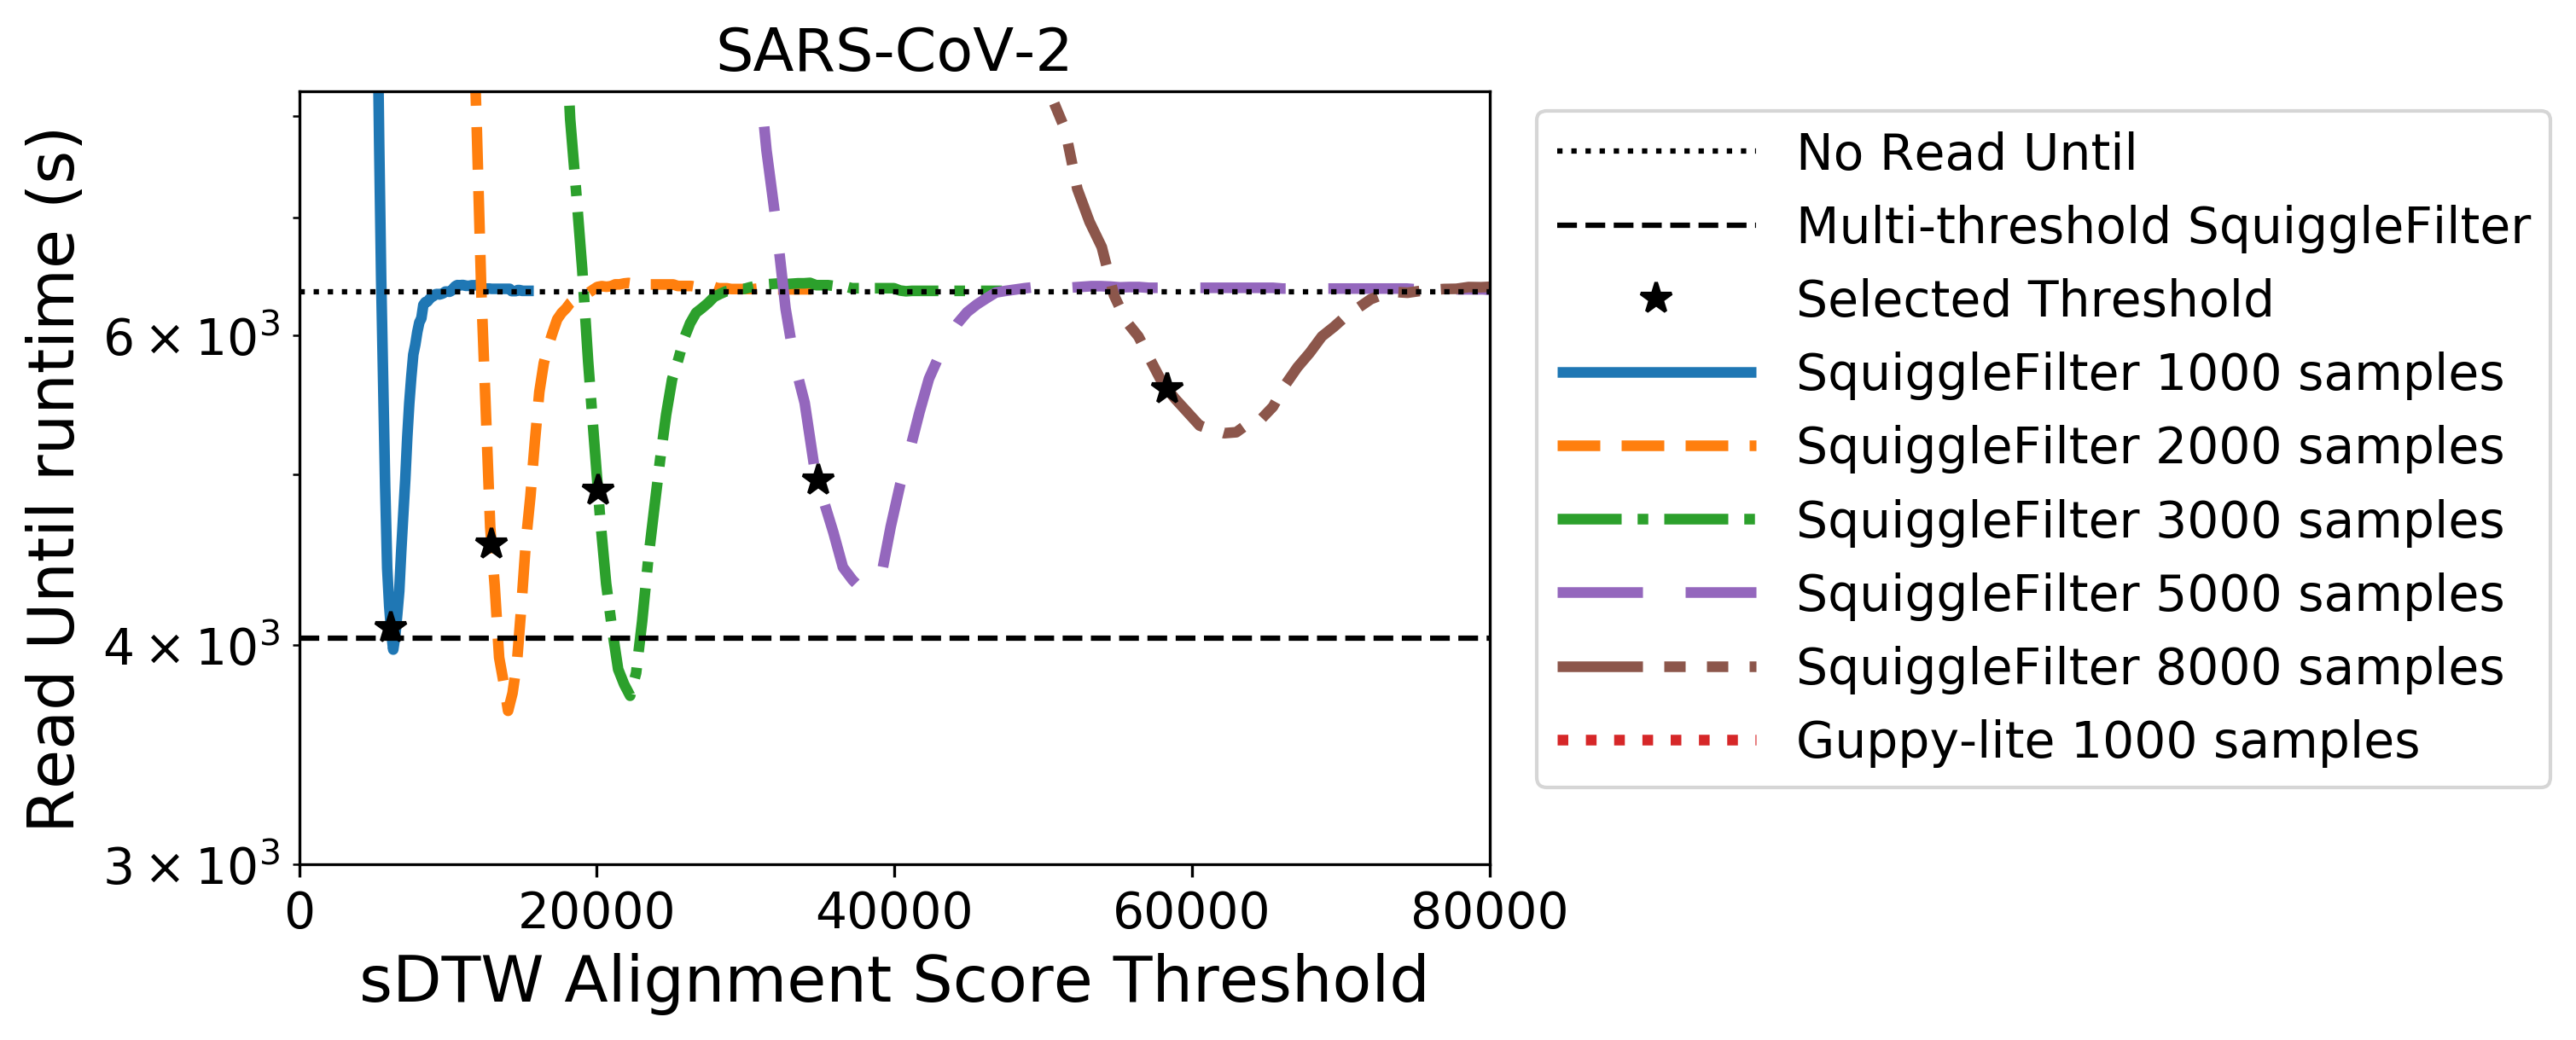

In [38]:
read_data = Reads(results_dir)
run = Run(read_data)
xmax = 80000
plt.plot(np.linspace(0,xmax,20), [run.get_simple_runtime()]*20, color='k', linestyle=':')

linestyles=['-', '--', '-.', ':', '-']
dashes = [[10,0], [4,2], [6,1.5,1,1.5], [8,4], [8,2,2,2,2,2]]
colors = ['C0', 'C1', 'C2', 'C4', 'C5']
j = 0
first=True
plot_indices = [0,1,2,4,7]
plot_prefixes = [1000,2000,3000,5000,8000]
threshs2 = [6170, 12935, 20093, 34879, 58345]
best_threshold_time = run.get_read_until_runtime(plot_indices[:5:4], threshs2[:5:4])
plt.plot(np.linspace(0,xmax,20), [best_threshold_time]*20, color='k', linestyle='--')

for i1, p1 in zip(plot_indices, plot_prefixes):
    max_score = max(np.max(virus_scores[i1]), np.max(other_scores[i1]))
    min_score = max(1, min(np.min(virus_scores[i1]), np.min(other_scores[i1])))
    times = []
    thresholds = np.linspace(min_score, max_score, 100)
    for t in thresholds:
        times.append(run.get_read_until_runtime([i1], [t]))
    
    if virus == "lambda":
        if first:
            best = np.argmin(times)
            first=False
            plt.plot(thresholds[best], times[best], marker='*', markersize=9, color='k', linestyle='', zorder=2)
        else:
            best = np.argmin(times)
            plt.plot(thresholds[best], times[best], marker='*', markersize=9, color='k', linestyle='', label='_nolegend_', zorder=2)
        print(f"{p1} samples: {times[best]} @ threshold {thresholds[best]}")
    else:
        threshs = [6170, 12935, 20093, 0, 34879, 0, 0, 58345]
        if first:
            best = threshs[i1]
            first=False
            time = np.interp(best, thresholds, times)
            plt.plot(best, time, marker='*', markersize=9, color='k', linestyle='', zorder=2)
        else:
            best = threshs[i1]
            time = np.interp(best, thresholds, times)
            plt.plot(best, time, marker='*', markersize=9, color='k', linestyle='', label='_nolegend_', zorder=2)
    
    plt.plot(thresholds, times, dashes=dashes[j], color=colors[j], linewidth=3, zorder=1)
    plt.ylabel('Read Until runtime (s)', fontsize=18)
    plt.xlabel('sDTW Alignment Score Threshold', fontsize=18)
    j+= 1

plt.xlim(0,xmax)
plt.ylim(3000, run.get_simple_runtime()*1.3)
plt.yscale('log')
if virus=='lambda':
    plt.title('Lambda Phage')
else:
    plt.title('SARS-CoV-2')
    plt.plot([], [], linestyle=':', linewidth=3, color='C3')
    leg = plt.legend(['No Read Until', 'Multi-threshold SquiggleFilter', 'Selected Threshold'] + [f'SquiggleFilter {l} samples' for l in plot_prefixes] + ['Guppy-lite 1000 samples'], 
                     loc=(1.04,0.1), handlelength=4)
    leg.legendHandles[2]._legmarker.set_markersize(9)
plt.show()

#### Basecall Align Read Until Runtime

In [ ]:
read_data = Reads(results_dir)
run = Run(read_data, 'ba')

plt.axhline(run.get_simple_runtime(), linestyle=':', color='red')
for i1, p1 in enumerate(prefix_lengths[:3]):
    max_score = max(np.max(-ba_virus_scores[i1]), np.max(-ba_other_scores[i1]))
    min_score = min(np.min(-ba_virus_scores[i1]), np.min(-ba_other_scores[i1]))
    times = []
    thresholds = np.linspace(min_score, max_score, 100)
    for t in thresholds:
        times.append(run.get_read_until_runtime([i1], [t]))
    plt.plot(thresholds, times)
    print(f"{p1}: {min(times)}")
#plt.axhline(132.3, linestyle=':', color='green')
plt.ylim(0, run.get_simple_runtime()*1.3)
#plt.ylim(0,600)
#plt.xlim(0, 100_000)
plt.legend(['no Read Until'] + list(prefix_lengths[:3]) + ['two thresholds'], loc='lower right')
print(run.get_read_until_runtime([0], [-1]))
plt.show()

Plot decrease in Read Until sequencing time as channels increases

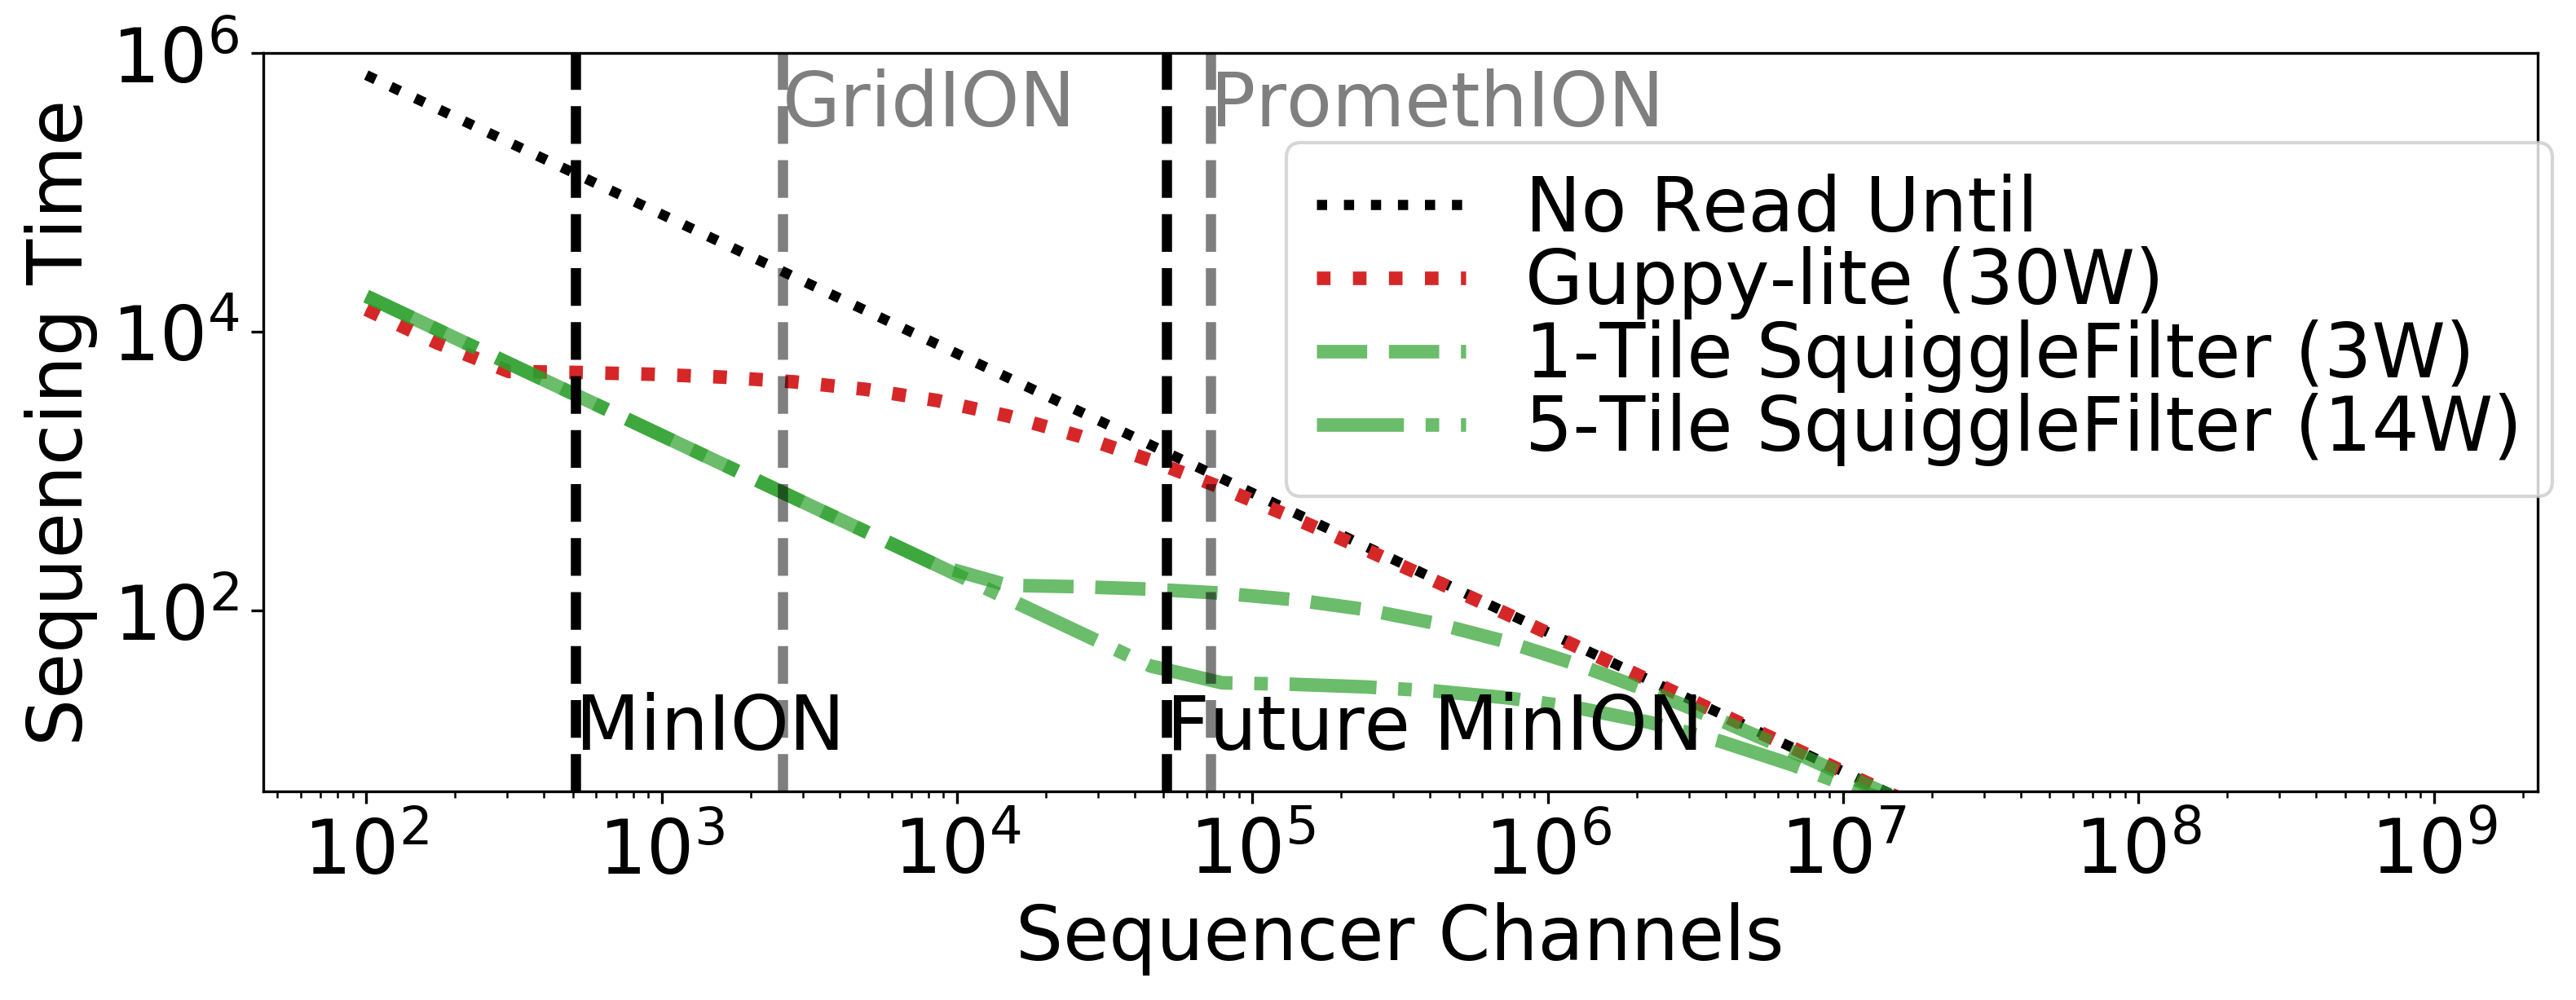

In [86]:
read_data = Reads(results_dir)
mpl.rcParams.update({'font.size': 22})

simple_runtimes = []
sf_runtimes = [[], []]
ba_runtimes = []
channels = np.logspace(2, 9, num=30)
for channel_count in channels:
    flowcell = Flowcell(channel_count)
    for i, w in enumerate([1,5]):
        sf_run = Run(read_data, 'sf', flowcell, w)
        sf_runtimes[i].append(sf_run.get_read_until_runtime(best_threshold_indices, best_threshold_values))
    ba_run = Run(read_data, 'ba', flowcell)
    simple_runtimes.append(sf_run.get_simple_runtime())
    ba_runtimes.append(ba_run.get_read_until_runtime([0], [-1]))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(channels, simple_runtimes, color='k', linestyle=':', linewidth=3)
ax.plot(channels, ba_runtimes, linestyle=':', color='C3', linewidth=4)
ax.plot(channels, sf_runtimes[0], linestyle='--', color='C2', linewidth=4, alpha=0.7)
ax.plot(channels, sf_runtimes[1], linestyle='-.', color='C2', linewidth=4, alpha=0.7)
ax.axvline(512, color='k', linestyle='--', linewidth=3)
ax.axvline(5*512, color='k', linestyle='--', alpha=0.5, linewidth=3)
ax.axvline(3000*24, color='k', linestyle='--', alpha=0.5, linewidth=3)
ax.axvline(100*512, color='k', linestyle='--', linewidth=3)
ax.text(512, 10, 'MinION', fontsize=22)
ax.text(5*512, 3*10**5, 'GridION', fontsize=22, alpha=0.5)
ax.text(3000*24, 3*10**5, 'PromethION', fontsize=22, alpha=0.5)
ax.text(100*512, 10, 'Future MinION', fontsize=22)
ax.set_ylim(5, 10**6)
#ax.plot([512,512], [4097,5413], marker='*', markersize=5, linestyle='', color='k')
ax.set_xlabel('Sequencer Channels', fontsize=22)
ax.set_ylabel('Sequencing Time', fontsize=22)
leg = ax.legend(['No Read Until', 'Guppy-lite (30W)', '1-Tile SquiggleFilter (3W)', '5-Tile SquiggleFilter (14W)'], 
                loc=(0.45,0.4), fontsize=22, labelspacing=0)
leg.legendHandles[0]._legmarker.set_markersize(9)
plt.show()

#### Plot Coverage

In [ ]:
depth_fn = f"{data_dir}/{virus}/{dna_type}/{other_ds}/depth.bed"
with open(depth_fn, 'r') as depth_file:
    covs = [int(x.split()[2]) for x in depth_file.readlines()]
plt.plot(covs)
plt.xlabel('Genome Position')
plt.ylabel('Read Depth')
plt.show()

plt.hist(covs, bins=100)
depth_mean = np.mean(covs)
depth_5 = np.percentile(covs, 5)
plt.axvline(depth_mean, color='k', linestyle=':')
plt.xlabel('Read Depths')
plt.ylabel('Counts')
print(f'Coverage Bias: {depth_mean/depth_5}')
plt.show()

In [ ]:
print(run.reads.avg_virus_length)